# Test Technique – Moov AI ✈
**Author** : Toufik Mechouma  
**Topic** : Data analysis  
**Aim** : SSF : Sotres Sales Forecasting

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap

In [3]:
class DataPreprocessor:
  """A class for preprocessing and feature engineering of sales data.

  Attributes:
      epsilon (float): Small value to avoid division by zero in calculations.
  """

  def __init__(self, epsilon=1e-6):

    """
    Initialize the DataPreprocessor with an epsilon value.

    Args:
        epsilon (float): Small value to avoid division by zero.
    """
    self.epsilon = epsilon

  def add_temporal_features(self, df):
    """
    Add temporal features to the dataframe based on order and ship dates.

    Args:
        df (pd.DataFrame): Input dataframe containing 'Order Date' and 'Ship Date'

    Returns:
        pd.DataFrame: Dataframe with added temporal features
    """
    # Ensure dates are in datetime format
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])

    # Extract temporal features from Order Date
    df['Year'] = df['Order Date'].dt.year
    df['Month'] = df['Order Date'].dt.month
    df['DayOfWeek'] = df['Order Date'].dt.day_name()

    # Calculate order processing time
    df['Order Processing Time'] = df['Ship Date'] - df['Order Date']
    df['Order Processing Time'] = df['Order Processing Time'].dt.days.astype('int64')

    # Add cyclical month features
    df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

  def add_interaction_features(self, df):
    """
    Add interaction features to the dataframe.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Dataframe with added interaction features
    """
    # Interaction features
    df['Quantity_Discount'] = df['Quantity'] * df['Discount']
    df['Sales_Per_Unit'] = df['Sales'] / (df['Quantity'] + self.epsilon)

    return df

  def preprocess(self, df):
    """
    Apply all feature engineering steps to the dataframe.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Processed dataframe with all new features
    """
    df = self.add_temporal_features(df)
    df = self.add_interaction_features(df)
    return df

In [37]:
class SalesPredictor:

  """A class for training and evaluating sales prediction models.

  Attributes:
      features (list): List of feature columns to use
      target (str): Name of target column
      random_state (int): Random seed for reproducibility
      test_size (float): Proportion of data for testing (0-1)
      model: Trained model instance
      X_train (pd.DataFrame): Training features
      X_test (pd.DataFrame): Test features
      y_train (pd.Series): Training target
      y_test (pd.Series): Test target
  """


  def __init__(self, features=None, random_state=42, test_size=0.2):
    """
    Initialize the SalesPredictor with default or custom parameters.

    Args:
        features (list): List of feature columns to use
        random_state (int): Random seed for reproducibility
        test_size (float): Proportion of data to use for testing (0-1)
    """
    self.features = features or [
        'Quantity', 'Discount', 'Profit', 'Order Processing Time',
        'Quantity_Discount', 'Sales_Per_Unit', 'Month_Sin', 'Month_Cos'
    ]
    self.target = 'Sales'
    self.random_state = random_state
    self.test_size = test_size
    self.model = None
    self.preprocessor = None
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None

  def create_pipeline(self):

    """Create the model pipeline with preprocessing and regressor."""
    self.model = Pipeline(steps=[
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=self.random_state))
    ])
    return self

  def train_test_split(self, df):
    """
    Split data into training and test sets.

    Args:
        df (pd.DataFrame): Preprocessed dataframe containing features and target
    """
    X = df[self.features]
    y = df[self.target]

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y,
        test_size=self.test_size,
        random_state=self.random_state
    )
    return self

  def fit(self):
    """Fit the model on training data."""
    if self.model is None:
      self.create_pipeline()

    self.model.fit(self.X_train, self.y_train)
    return self

  def evaluate(self):
    """Evaluate model performance on test data."""
    if self.model is None:
      raise ValueError("Model has not been trained. Call fit() first.")

    y_pred = self.model.predict(self.X_test)

    metrics = {
        'MAE': mean_absolute_error(self.y_test, y_pred),
        'MSE': mean_squared_error(self.y_test, y_pred),
        'RMSE': mean_squared_error(self.y_test, y_pred, squared=False),
        'R2': r2_score(self.y_test, y_pred)
    }

    return metrics

  def predict(self, new_data):
    """
    Make predictions on new data.

    Args:
        new_data (pd.DataFrame): Dataframe containing the required features

    Returns:
        array: Predicted values
    """
    if self.model is None:
      raise ValueError("Model has not been trained. Call fit() first.")

    return self.model.predict(new_data[self.features])

In [38]:
class ModelComparator:

  """A class for comparing multiple regression models with hyperparameter tuning.

  Attributes:
      random_state (int): Random seed for reproducibility
      param_grids (dict): Hyperparameter grids for tuning
      models (dict): Dictionary of model instances
      results (dict): Training results storage
      best_params (dict): Best parameters from tuning
      comparison_df (pd.DataFrame): Model comparison results
  """
  def __init__(self, random_state=42):
      """
      Initialize the ModelComparator with default parameters.

      Args:
          random_state (int): Random seed for reproducibility
      """
      self.random_state = random_state
      self.param_grids = {
          "Ridge": {'model__alpha': [0.1, 1.0, 10.0]},
          "Lasso": {'model__alpha': [0.01, 0.1, 1.0]},
          "Random Forest": {
              'model__n_estimators': [100, 200],
              'model__max_depth': [None, 10, 20]
          },
          "Gradient Boosting": {
              'model__n_estimators': [100, 200],
              'model__learning_rate': [0.05, 0.1],
              'model__max_depth': [3, 5]
          },
          "XGBoost": {
              'model__n_estimators': [100, 200],
              'model__learning_rate': [0.05, 0.1],
              'model__max_depth': [3, 5]
          },
          "SVR": {
              'model__C': [0.1, 1, 10],
              'model__kernel': ['rbf', 'linear']
          }
      }

      self.models = {
          "Linear Regression": LinearRegression(),
          "Ridge": Ridge(random_state=random_state),
          "Lasso": Lasso(random_state=random_state),
          "Random Forest": RandomForestRegressor(random_state=random_state),
          "Gradient Boosting": GradientBoostingRegressor(random_state=random_state),
          "XGBoost": XGBRegressor(random_state=random_state),
          "SVR": SVR()
      }

      self.results = {}
      self.best_params = {}
      self.comparison_df = None

  def train_models(self, X_train, y_train, X_test, y_test):

    """
    Train and evaluate multiple models with optional hyperparameter tuning.

    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): Training target
        X_test (pd.DataFrame): Test features
        y_test (pd.Series): Test target
    """
    self.results = {}
    self.best_params = {}

    for name, model in self.models.items():
      print(f"\nTraining {name}...")
      pipe = Pipeline(steps=[('model', model)])

      if name in self.param_grids:
          grid = GridSearchCV(
              pipe,
              self.param_grids[name],
              cv=5,
              scoring='r2',
              n_jobs=-1,
              verbose=1
          )
          grid.fit(X_train, y_train)
          best_model = grid.best_estimator_
          self.best_params[name] = grid.best_params_
      else:
          best_model = pipe.fit(X_train, y_train)

      preds = best_model.predict(X_test)
      self.results[name] = {
            'model': best_model,
            'predictions': preds
        }

  def evaluate_models(self, y_test):
    """
    Evaluate all trained models and store results.

    Args:
        y_test (pd.Series): True target values for evaluation
    """
    comparison = {}

    for name, result in self.results.items():
        preds = result['predictions']
        comparison[name] = self._calculate_metrics(y_test, preds)

    self.comparison_df = pd.DataFrame(comparison).T
    self.comparison_df = self.comparison_df.sort_values(by="R²", ascending=False)
    return self.comparison_df

  def _calculate_metrics(self, y_true, y_pred):
    """Calculate evaluation metrics for a single model."""
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

  def plot_comparison(self, figsize=(10, 6), rotation=15):
    """
    Create a bar plot comparing model performance metrics.

    Args:
        figsize (tuple): Figure size (width, height)
        rotation (int): Rotation angle for x-axis labels
    """
    if self.comparison_df is None:
      raise ValueError("Models have not been evaluated. Call evaluate_models() first.")

    # Create plot
    ax = self.comparison_df.plot(kind="bar", figsize=figsize)

    # Add values on bars
    for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', padding=3)

    # Customize plot
    plt.title("Model Comparison (Lower is better for MAE/RMSE, Higher for R²)")
    plt.ylabel("Score")
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

  def get_best_model(self):
    """Return the best performing model based on R² score."""
    if self.comparison_df is None:
      raise ValueError("Models have not been evaluated. Call evaluate_models() first.")

    best_model_name = self.comparison_df.index[0]
    return self.results[best_model_name]['model'], best_model_name

  def print_results(self):
    """Print model comparison results and best hyperparameters."""
    if self.comparison_df is None:
      raise ValueError("Models have not been evaluated. Call evaluate_models() first.")

    print("\nModel Comparison (Sorted by R²):")
    print(self.comparison_df)

    if self.best_params:
      print("\nBest Hyperparameters:")
      for name, params in self.best_params.items():
          print(f"{name}: {params}")

In [39]:
class DataAssessment:


  """A class for assessing and cleaning data quality in pandas DataFrames.

  The DataAssessment class provides methods to evaluate data quality across multiple
  dimensions including accuracy, completeness, and coherence, along with reporting
  and cleaning capabilities.

  Attributes:
      df (pd.DataFrame): The pandas DataFrame to be assessed and cleaned.
  """

  def __init__(self):
    """Initializes the DataAssessment with a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to be assessed. Must be a valid pandas DataFrame.
    """
    self.df = pd.DataFrame()

  def load_data(self,path):
    """Loads data from a CSV file into a pandas DataFrame.

    Args:
        path (str): The file path of the CSV file to be loaded.
    """
    # load the dataset
    self.df = pd.read_csv(path, encoding='latin-1')


  def visualize_outliers(self,df:pd.DataFrame,col:str):
    """Visualize with boxplot the distribution of a variable with outliers."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f"{col}  Distribution with Outliers")
    plt.show()

  def visualize_duplicates(self, df):
    """Visualize duplicate rows in the DataFrame."""
    # Create mask for all duplicate rows (keeping all occurrences)
    dupes_mask = df.duplicated(keep=False)
    # Check if there are any duplicate rows
    duplicate_count = dupes_mask.sum()
    if duplicate_count == 0:
      print("No duplicate rows found.")
    else:
      # Create a boolean dataframe indicating duplicates
      bool_df = pd.DataFrame(False, index=df.index, columns=df.columns)
      for col in df.columns:
          bool_df[col] = dupes_mask

      # Set up the visualization
      plt.figure(figsize=(12, 6))
      # Create heatmap - only showing duplicate rows
      sns.heatmap(
          bool_df[dupes_mask],  # Only show duplicate rows
          cmap=['white', 'red'],  # Simple two-color scheme
          cbar=False,
          yticklabels=False,  # Hide row labels for cleaner display
          linewidths=0.5,
          linecolor='lightgray'
      )
      # Customize the plot
      plt.title("Duplicate Rows Visualization", pad=20, fontsize=14)
      plt.xlabel("Columns", labelpad=10)
      plt.ylabel("Duplicate Rows", labelpad=10)

      # Add count of duplicates to the plot
      plt.text(0.5, -0.1,
                f"Total duplicate rows: {duplicate_count} ({duplicate_count/len(df):.1%})",
                ha='center', transform=plt.gca().transAxes)

      plt.tight_layout()
      plt.show()

  def distribution_analysis(self,df:pd.DataFrame, col:str):
    """Visualize the distribution of numerical columns in the DataFrame."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')


  def print_outliers_report(self, outliers_dict:dict):
    print("---------Outliers Analysis Report----------")
    for cc in outliers_dict.keys():
      print(f"Column : {cc}")
      print(f"z_scores : {outliers_dict[cc]['z_scores']}")
      print(f"nbr_outliers : {outliers_dict[cc]['nbr_outliers']}")
      print(f"outliers_percent : {outliers_dict[cc]['outliers_percent']:.2f}%")
      print('----------------------------------------\n')

  def get_outliers(self, df:pd.DataFrame, threshold: float = 3.0):

    """Identifies outliers in a specified column of the DataFrame.

    Args:
        column (str): The name of the column to analyze for outliers.
        threshold (float, optional): The z-score threshold for identifying outliers.
            Defaults to 3.0.
    """
    outliers_dict = {}
    col_outliers_dict = {}
    col_outliers_dict_keys = ['z_scores', 'nbr_outliers', 'outliers_percent']
    for c in df.columns.tolist():
      # Check if the column is numeric before calculating z-scores
      if pd.api.types.is_numeric_dtype(df[c]):
        z_scores = np.abs(stats.zscore(df[c]))
        outliers = df[z_scores > 3]
        nbr_outliers = len(outliers)
        outliers_percent = (len(outliers)/df.shape[0])*100
        values = [z_scores,nbr_outliers, outliers_percent]
        col_outliers_dict = {k: v for k, v in zip(col_outliers_dict_keys, values)}
        outliers_dict[c] = col_outliers_dict
    return outliers_dict


  def check_accuracy(self,df:pd.DataFrame,dtype_mapping:dict):
    """Assesses data accuracy by checking for type errors and outliers.

    Evaluates each column for:
    - Type consistency
    - Statistical outliers
    - Invalid values based on data type

    Returns:
        Accuracy Report
    Note:
        Implementation pending - currently returns empty dict.
    """
    shape = self.df.shape # the Dataframe shape
    print("The dimension of the Dataset is :",shape)
    print(" ")
    df = df.astype(dtype_mapping) # type conversion
    print("-----The dupplicates Analysis Report-------")
    print(" ")
    duplicate_rows = df[df.duplicated(keep=False)] # Check for completely identical rows
    nbr_duplicated_rows = duplicate_rows.shape[0] # number of duplicate rows
    print("The number of duplicate rows is :",nbr_duplicated_rows)
    perc_duplicated_rows = (nbr_duplicated_rows / shape[0]) * 100 # percentage of duplicate rows
    print(f"The percentage of duplicate rows is : {perc_duplicated_rows:.2f}%")



  def get_missing_values(self,df:pd.DataFrame):
    # Check for missing values in entire DataFrame
    miss_val = df.isnull().sum()
    print('-------------------------------')
    print("Missing values count per column:")
    print(miss_val)
    print('-------------------------------')
    # Check percentage of missing values
    miss_val_perc = df.isnull().mean() * 100
    print("Missing values percentage per column:")
    for column, percentage in miss_val_perc.items():
      print(f"{column}: {percentage:.2f}%")
    print('-------------------------------')

  def visualize_missing_values(self,df:pd.DataFrame):
    # Create a heatmap of missing values (True if missing, False otherwise)
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()

  def check_completeness(self):
    """Assesses data completeness by checking for missing values."""
    self.get_missing_values(self.df)


In [40]:
# Columns types defintion
dtype_mapping = {
    'Row ID': 'int32',
    'Order ID': 'string',
    'Order Date': 'datetime64[ns]',
    'Ship Date': 'datetime64[ns]',
    'Ship Mode': 'category',
    'Customer ID': 'string',
    'Customer Name': 'string',
    'Segment': 'category',
    'Country': 'category',
    'City': 'string',
    'State': 'category',
    'Postal Code': 'string',
    'Region': 'category',
    'Product ID': 'string',
    'Category': 'category',
    'Sub-Category': 'category',
    'Product Name': 'string',
    'Sales': 'float64',
    'Quantity': 'int32',
    'Discount': 'float64',
    'Profit': 'float64'
}

In [41]:
# Initialize all components
path='/content/stores_sales_forecasting.csv'
data_assessment = DataAssessment()
data_assessment.load_data(path)
preprocessor = DataPreprocessor()
predictor = SalesPredictor()
model_comparator = ModelComparator(random_state=42)

## Question 1 – Préparation des données
Q1.
1. Si tu rencontres des problèmes de qualité des données durant ta manipulation des données de ventes, comment les as-tu résolus ?
   - Réponse : Il y a principalement trois types de problèmes les doublons qu'il faut éliminer, les NaN values a traiter avec des techniques d'imputation moyenne, médiane etc. Enfin, le problèmes des valeurs abbérrantes (outliers) qui peut etre prise en charge par des méthodes statistiques notamment IQR,Z-Score ou encore la visualisation. Le workflow du travail ci-dessous considère les trois problèmes.

2. Limite-toi aux trois enjeux les plus pertinents selon toi (appuie-toi avec un visuel).
   - Réponse : Oui, je me suis limité au trois mentionné ci-dessus.

3. Est-ce que les insights trouvés peuvent être transformés en features qui faciliteront l'apprentissage du modèle ML?      

## Réponse 1

   - Oui, les insights ont été discutés dans la section Insights  

### 📈 Duplicates statistics

In [42]:
data_assessment.check_accuracy(data_assessment.df,dtype_mapping)

The dimension of the Dataset is : (2121, 21)
 
-----The dupplicates Analysis Report-------
 
The number of duplicate rows is : 0
The percentage of duplicate rows is : 0.00%


### 🔍 Duplicates visualization

In [43]:
data_assessment.visualize_duplicates(data_assessment.df)

No duplicate rows found.


### 📈 Outliers statistics

In [44]:
data_assessment.print_outliers_report(data_assessment.get_outliers(data_assessment.df))

---------Outliers Analysis Report----------
Column : Row ID
z_scores : [1.74715387 1.74680726 1.74611403 ... 1.71204641 1.71516593 1.71551254]
nbr_outliers : 0
outliers_percent : 0.00%
----------------------------------------

Column : Postal Code
z_scores : [0.41255162 0.41255162 0.69496374 ... 0.45821648 0.69902521 1.1440479 ]
nbr_outliers : 0
outliers_percent : 0.00%
----------------------------------------

Column : Sales
z_scores : [0.17468055 0.75956093 1.20809047 ... 0.5244993  0.64522434 0.51261206]
nbr_outliers : 45
outliers_percent : 2.12%
----------------------------------------

Column : Quantity
z_scores : [0.79295253 0.34872318 0.53973552 ... 1.23718188 0.34872318 0.79295253]
nbr_outliers : 27
outliers_percent : 1.27%
----------------------------------------

Column : Discount
z_scores : [0.95822801 0.95822801 1.52104961 ... 0.95822801 0.14367316 0.95822801]
nbr_outliers : 0
outliers_percent : 0.00%
----------------------------------------

Column : Profit
z_scores : [0.2

### Handle Outliers :

  - Sales outliers_percent = 2.12%
  - Quantity outliers_percent : 1.27%
  - Profit outliers_percent : 1.27%

Based on the bellow investigation and due to the weak percentage, i consider this to be a legitimate values and reflect real world facts. Thus, I will keep them.

Otherwise i would use the following techniques to handle outliers.
1. Remove Outliers (Trimming)
2. Winsorize (Capping)
3. Log Transformation
4. Impute with Median/Mean


### 🔍 Outliers visualization

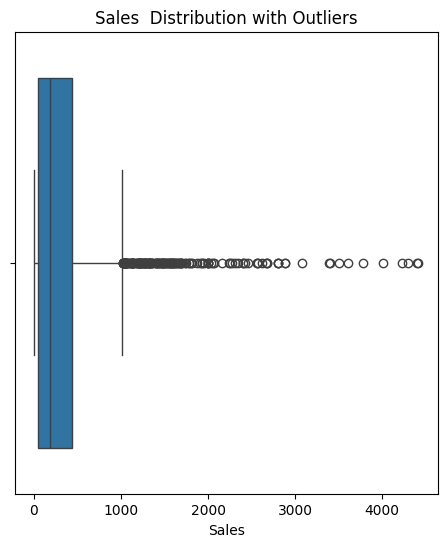

In [45]:
data_assessment.visualize_outliers(data_assessment.df,'Sales')

### Sales Distribution with Outliers Interpretation :
- This boxplot of sales distribution reveals that most transactions fall within a moderate range (likely $1000-$3000), with a concentration of smaller sales skewing the distribution to the right.

- The median sits closer to the lower end of the interquartile range, indicating that at least half of all sales are relatively modest in value.

- Beyond the upper whisker (approximately $4000), several high-value outliers appear, representing exceptionally large transactions that deviate significantly from typical order patterns.

- These outliers could stem from bulk purchases, premium product sales, or corporate orders, and warrant targeted analysis to determine whether they represent strategic opportunities or anomalies.

- The overall pattern suggests a customer base dominated by small to medium-sized purchases, with occasional high-impact sales that disproportionately contribute to total revenue.

- Businesses should investigate whether these outliers follow predictable patterns (like seasonal trends or specific customer segments) that could be intentionally replicated to drive revenue growth.

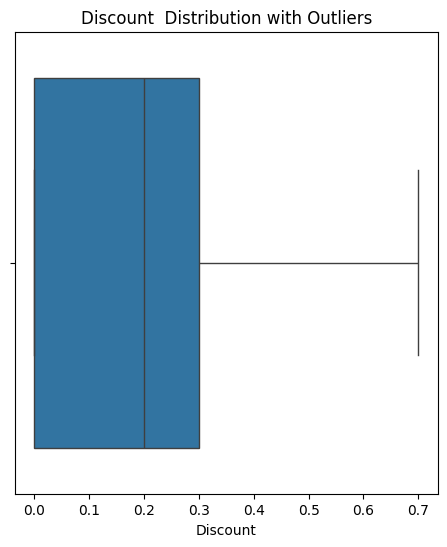

In [46]:
data_assessment.visualize_outliers(data_assessment.df,'Discount')

### Discount Distribution with Outliers Interpretation :
- This boxplot of discount distribution reveals that most products are sold with little to no discount (median likely near 0.0-0.1), as shown by the box's position close to zero.

- The interquartile range remains narrow, indicating consistent low discounting, with whiskers extending to approximately 0.4-0.5, beyond which lie outliers representing rare deep discounts (0.6-0.7).

- These extreme values could reflect clearance sales, promotional events, or pricing anomalies, suggesting minimal but strategic use of heavy discounts in the business model.

- The concentration near zero implies most sales occur at or near full price, which may indicate strong product value or limited price-based promotions.



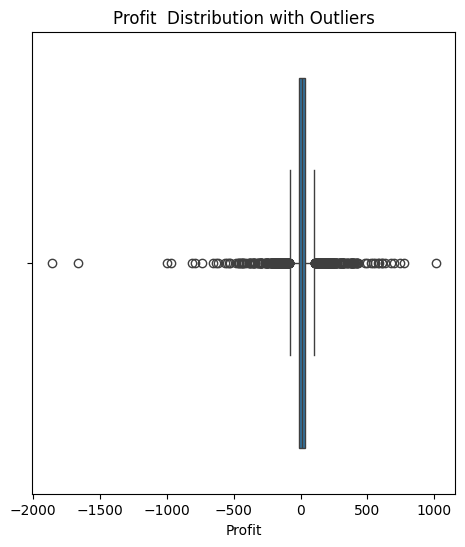

In [47]:
data_assessment.visualize_outliers(data_assessment.df,'Profit')

### Profit Distribution with Outliers Interpretation :

- This boxplot of profit distribution reveals a concerning pattern where the interquartile range spans from losses (-500 to 0) to modest gains (0 to 500), with the median hovering near the break-even point.

- The lower whisker extends to -2000, indicating significant losses in some transactions, while the upper whisker reaches approximately $1000, showing limited profitable outliers.

- The concentration of data near zero profit and the substantial left tail suggest that many transactions are either unprofitable or barely breaking even, with only a few delivering meaningful profits.

- This could indicate pricing strategy issues, high operational costs, or problematic product lines. The presence of extreme losses (-1500 to -2000) warrants immediate investigation into specific customers, products, or discount practices causing these substantial negative margins.

- The business should prioritize identifying and addressing the root causes of these losses while analyzing the few high-profit outliers for replicable success factors.

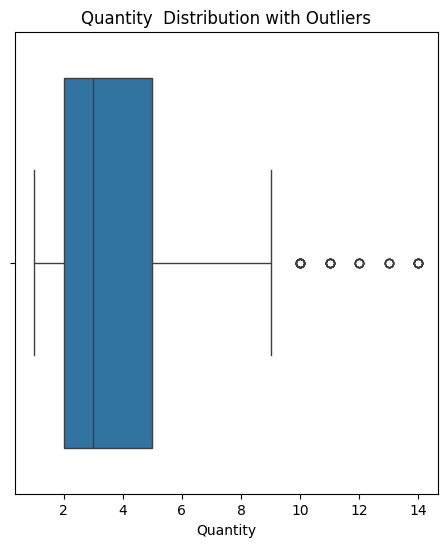

In [48]:
data_assessment.visualize_outliers(data_assessment.df,'Quantity')

### Quantity Distribution with Outliers Interpretation :

- This boxplot of quantity distribution shows that most orders contain relatively few items, with the interquartile range likely spanning 2-6 units and the median positioned near the lower end, indicating a right-skewed distribution where small orders dominate.

- The upper whisker extends to approximately 8-10 units, marking the threshold for typical order sizes, while outliers beyond this point (10-14+ units) represent unusually large orders that deviate significantly from normal purchasing behavior.

- These outliers could indicate bulk purchases, wholesale transactions, or stock-up events, suggesting opportunities to analyze customer segments or product categories that drive these larger orders.

- The overall pattern confirms the business primarily serves customers making small-quantity purchases, with occasional high-volume transactions that may disproportionately impact inventory or revenue.

### 📈 Missing values statistics

In [49]:
data_assessment.check_completeness()

-------------------------------
Missing values count per column:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64
-------------------------------
Missing values percentage per column:
Row ID: 0.00%
Order ID: 0.00%
Order Date: 0.00%
Ship Date: 0.00%
Ship Mode: 0.00%
Customer ID: 0.00%
Customer Name: 0.00%
Segment: 0.00%
Country: 0.00%
City: 0.00%
State: 0.00%
Postal Code: 0.00%
Region: 0.00%
Product ID: 0.00%
Category: 0.00%
Sub-Category: 0.00%
Product Name: 0.00%
Sales: 0.00%
Quantity: 0.00%
Discount: 0.00%
Profit: 0.00%
-------------------------------


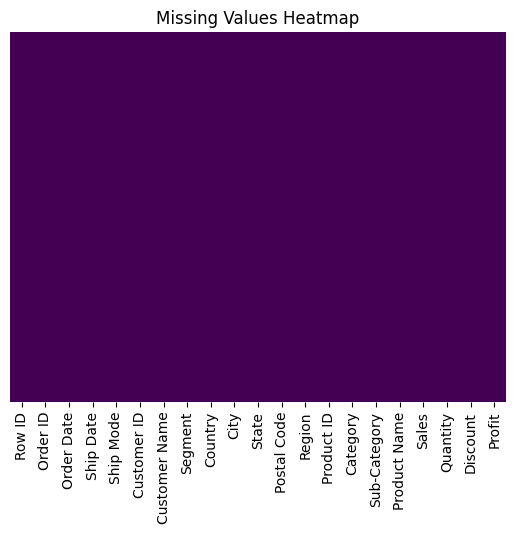

In [50]:
data_assessment.visualize_missing_values(data_assessment.df)

### Missing values HeatMap Interpretation :

The heatmap appears to show no missing values (null/NA values) across all variables in your dataset, as all fields are listed without any visual indication of missing data (which would typically be shown with color coding if missing values were present)

### 🔍 Variables distribution

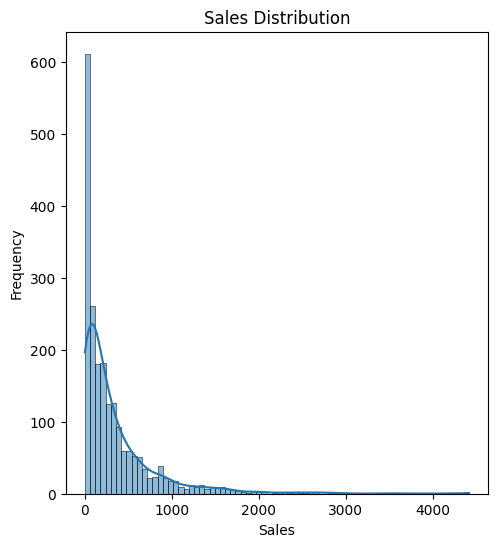

In [51]:
data_assessment.distribution_analysis(data_assessment.df,'Sales')

### Sales Distribution Interpretation :

- The sales distribution histogram shows a right-skewed pattern, indicating that most sales are concentrated at lower values, with fewer instances of higher sales amounts.

- The highest frequency (approximately 4000–5000 occurrences) corresponds to the smallest sales values, suggesting that the majority of transactions are modest in size.

- As sales amounts increase, their frequency drops sharply, with very few transactions reaching the highest sales brackets.

- This is typical in retail data, where many small purchases outweigh fewer large orders.

- Further analysis could explore whether these high-value sales represent bulk purchases, specific product categories, or seasonal spikes.


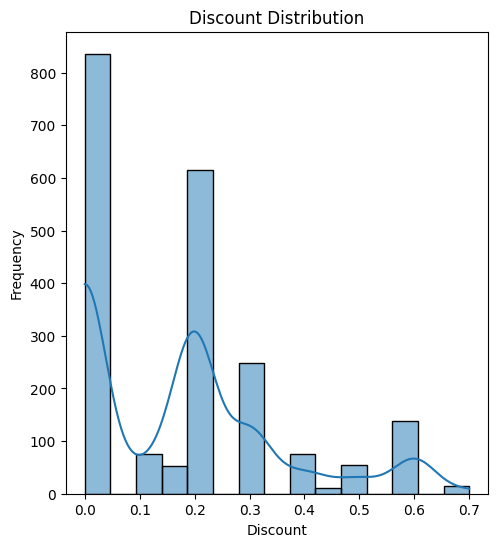

In [52]:
data_assessment.distribution_analysis(data_assessment.df,'Discount')

### Discount Distribution Interpretation :

- The discount distribution histogram reveals that most products are sold without discounts (peak at 0.0), with a sharp decline as discount rates increase.

- The frequency drops significantly beyond 0.2 (20% discount), indicating that higher discounts are relatively uncommon in this dataset.

- This pattern suggests the business primarily operates on minimal or no discounts, with occasional moderate discounts (10-20%) and rare deep discounts (30%+).

- Such a distribution could reflect a premium pricing strategy, seasonal promotions, or clearance events for specific products. Further segmentation by product category or customer segment could provide deeper insights into discounting strategies.

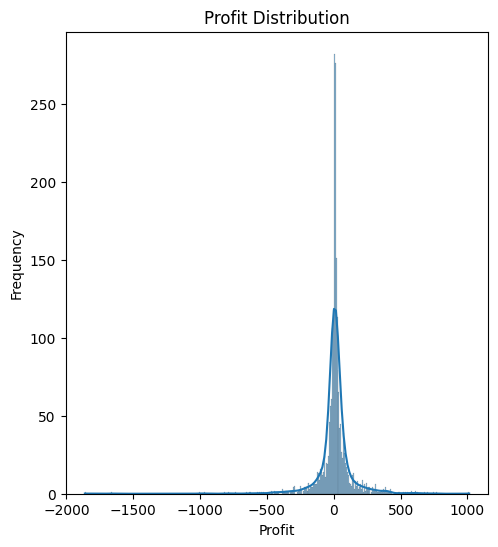

In [53]:
data_assessment.distribution_analysis(data_assessment.df,'Profit')

### Profit Distribution Interpretation :

- The profit distribution shows a concentrated peak around small positive values (near 0 to 500), indicating that most transactions generate modest profits. However, the presence of a left tail extending into negative values (losses) reveals that a subset of transactions is unprofitable, with some significant losses reaching -2000.

- This pattern suggests:

  1. Core profitability: The majority of sales yield low-to-moderate gains, typical of stable operations.

  2. Risk exposure: The left skew highlights problematic transactions—potentially from steep discounts, low-margin products, or operational inefficiencies.

  3. Outliers: Extreme losses (-2000) warrant investigation into specific products, customers, or promotions causing these outliers.

- Actionable insight: Prioritize analyzing loss-making segments ( high-discount sales or specific categories) to improve overall profitability. A breakdown by product or region could pinpoint root causes.

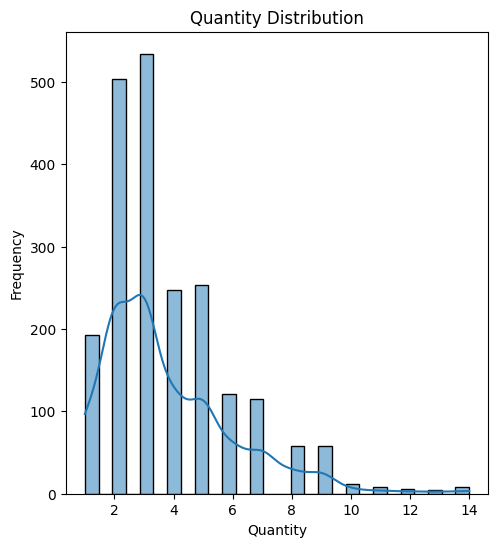

In [54]:
data_assessment.distribution_analysis(data_assessment.df,'Quantity')

### Profit Distribution Interpretation :

- The quantity distribution histogram reveals a right-skewed pattern, with the highest frequency (approximately 400 occurrences) at the lowest quantity (2 units). As order quantities increase, their frequency declines sharply—most transactions involve small quantities (2–6 units), while bulk orders (8+ units) are rare.

- Key Insights:

  1. Dominance of small orders: The business primarily serves customers making modest purchases, typical in B2C or retail environments.

  2. Limited bulk transactions: The sparse tail suggests minimal wholesale or high-volume activity, which may represent untapped opportunities.

  3. Potential action: Investigate whether low-quantity sales correlate with profitability (if small orders have higher margins) or explore incentives to boost larger purchases.

- Note: If quantities beyond 14 exist but aren’t shown, outliers might be trimmed—confirm the full data range for completeness.

## Question 2 – Insights et interprétation

In [55]:
# Now we need to work on another dataframe to keep our data safe
df=data_assessment.df

## 1.INSIGHTS FOR MANAGERS

In [57]:
# Load and preprocess in global dataframe
df = data_assessment.df
processed_df = preprocessor.preprocess(df)

###  1.1 Insights from temporal features :

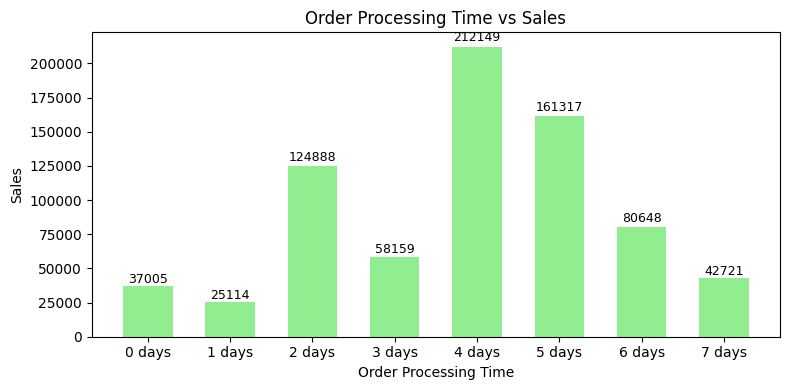

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Order Processing Time and sum Sales
proces_time_s = df.groupby('Order Processing Time', as_index=False)['Sales'].sum()

# Convert 'Order Processing Time' to a numerical format (number of days)
proces_time_s['Order Processing Time (days)'] = proces_time_s['Order Processing Time']

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

# Use the numerical representation for the x-axis
x = proces_time_s['Order Processing Time (days)']
y = proces_time_s['Sales']
bars = ax.bar(x, y, color='lightgreen', width=0.6)

# Add profit values on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval,
            f'{yval:.0f}', ha='center', va='bottom', fontsize=9)

# Set X-axis ticks and labels with days
ax.set_xticks(x) # Set ticks at the numerical day values
ax.set_xticklabels([f'{day} days' for day in x]) # Label with 'X days'
ax.set_xlabel('Order Processing Time')
ax.set_ylabel('Sales')
ax.set_title('Order Processing Time vs Sales')

plt.tight_layout()
plt.show()

The above histogram does not show any clear correlation between the order processing time and the sales. This means it is a weak feature

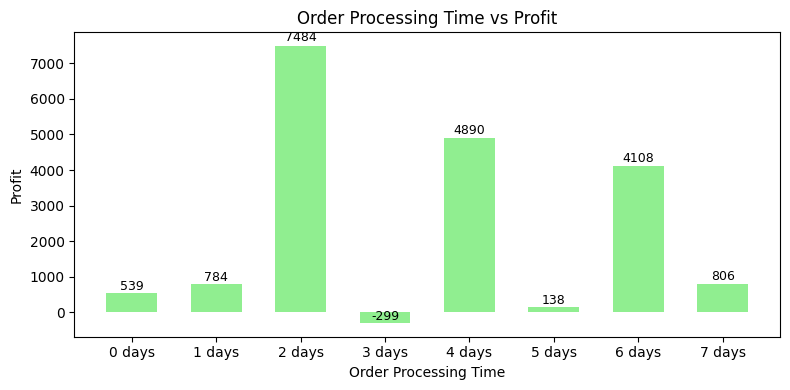

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Order Processing Time and sum Profit
proces_time_p = df.groupby('Order Processing Time', as_index=False)['Profit'].sum()

# Convert 'Order Processing Time' to a numerical format (number of days)
proces_time_p['Order Processing Time (days)'] = proces_time_p['Order Processing Time']

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

# Use the numerical representation for the x-axis
x = proces_time_p['Order Processing Time (days)']
y = proces_time_p['Profit']
bars = ax.bar(x, y, color='lightgreen', width=0.6)

# Add profit values on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval,
            f'{yval:.0f}', ha='center', va='bottom', fontsize=9)

# Set X-axis ticks and labels with days
ax.set_xticks(x) # Set ticks at the numerical day values
ax.set_xticklabels([f'{day} days' for day in x]) # Label with 'X days'
ax.set_xlabel('Order Processing Time')
ax.set_ylabel('Profit')
ax.set_title('Order Processing Time vs Profit')

plt.tight_layout()
plt.show()

We conclude that there is no clear correlation between the order processing time and the profit. This means it is a weak feature

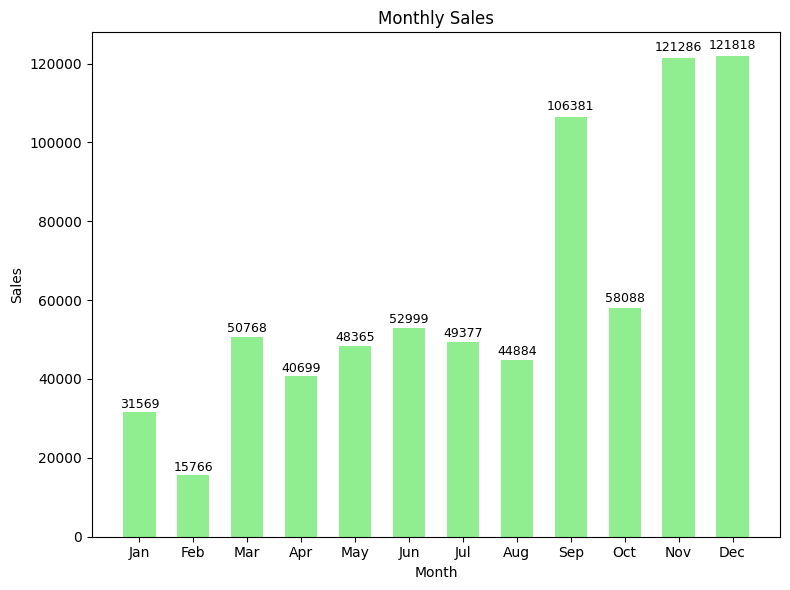

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Month (as number) and sum Profit
monthly_sales = df.groupby('Month', as_index=False)['Sales'].sum()

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Use sorted month numbers as x values
x = monthly_sales['Month']
y = monthly_sales['Sales']
bars = ax.bar(x, y, color='lightgreen', width=0.6)

# Add profit values on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval,
            f'{yval:.0f}', ha='center', va='bottom', fontsize=9)

# Set X-axis ticks and labels with month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales')

plt.tight_layout()
plt.show()

- The histogram shows strong seasonal variation in monthly sales, peaking at 120,000 and dropping to 15,766, indicating clear high and low demand period.
- Sales rise steadily from mid-year (May-Jul) before declining in August and sharply increasing from sep to Dec.
- This pattern suggests opportunities to align marketing, inventory, and staffing with peak seasons while optimizing costs during slower months.
- Further analysis of external factors (e.g., holidays, promotions) could help sustain growth and mitigate downturns.

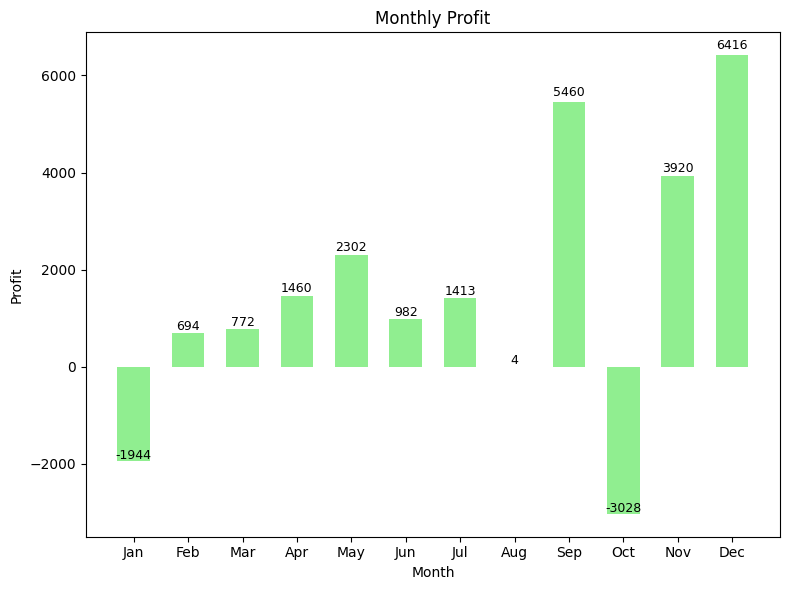

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Month (as number) and sum Profit
monthly_profit = df.groupby('Month', as_index=False)['Profit'].sum()

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Use sorted month numbers as x values
x = monthly_profit['Month']
y = monthly_profit['Profit']
bars = ax.bar(x, y, color='lightgreen', width=0.6)

# Add profit values on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval,
            f'{yval:.0f}', ha='center', va='bottom', fontsize=9)

# Set X-axis ticks and labels with month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.set_xlabel('Month')
ax.set_ylabel('Profit')
ax.set_title('Monthly Profit')

plt.tight_layout()
plt.show()

- The histogram reveals significant monthly profit fluctuations, with peaks up to 6000 and losses dipping to -2000, suggesting strong seasonal trends or inconsistent performance.
- The recurring pattern indicates potential opportunities to capitalize on high-profit months while addressing challenges in low periods.
- Managers should analyze the drivers behind these fluctuations such as demand cycles or operational inefficiencies to optimize strategies for more stable, year round profitability.

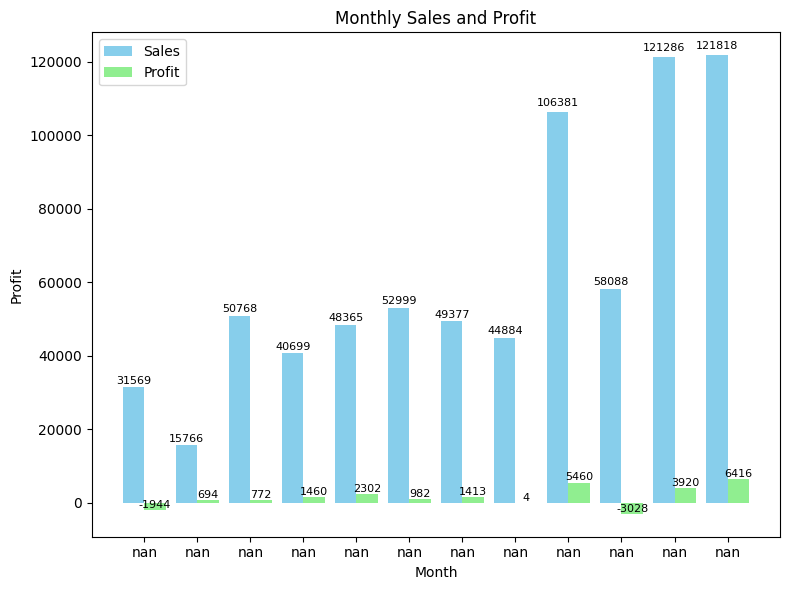

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Group by Month
monthly_data = df.groupby('Month')[['Sales', 'Profit']].sum().reset_index()

# Ensure correct order of months
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
monthly_data['Month'] = pd.Categorical(monthly_data['Month'], categories=month_order, ordered=True)
monthly_data = monthly_data.sort_values('Month')

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.4
x = range(len(monthly_data))

# Bars
bars1 = ax.bar([i - bar_width/2 for i in x], monthly_data['Sales'],
               width=bar_width, label='Sales', color='skyblue')

bars2 = ax.bar([i + bar_width/2 for i in x], monthly_data['Profit'],
               width=bar_width, label='Profit', color='lightgreen')

# Add values on top
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval,
            f'{yval:.0f}', ha='center', va='bottom', fontsize=8)

# Labels and formatting
ax.set_xlabel('Month')
ax.set_ylabel('Profit')
ax.set_title('Monthly Sales and Profit')
ax.set_xticks(x)
ax.set_xticklabels(monthly_data['Month'])
ax.legend()
plt.tight_layout()
plt.show()

- Sales increase throughout the year, with notable peaks in September, November, and December—especially in the last two months, where sales exceed 120,000.
- Profit follows a less consistent pattern, remaining modest for most months, turning negative in January and October, and peaking in December at 6,416.
- This suggests that while sales volume is high toward year-end, profitability varies and does not always correlate directly with sales figures.

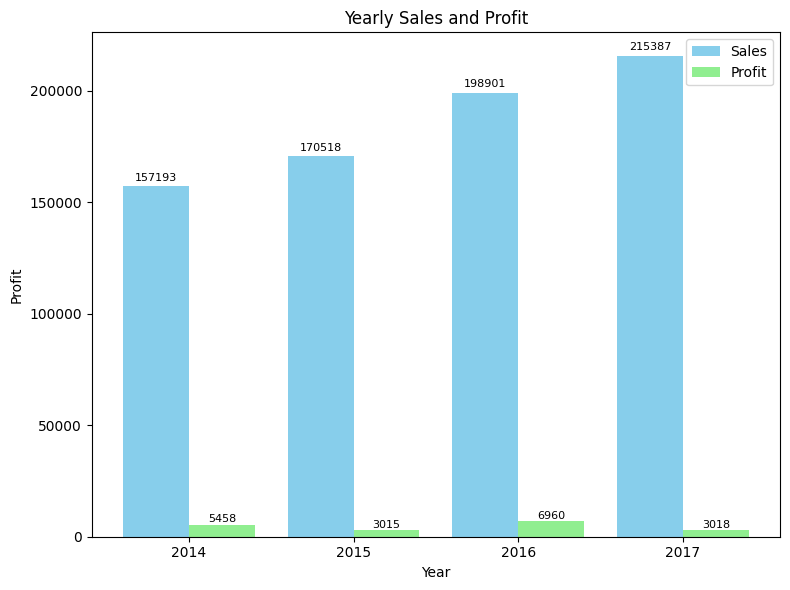

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year
yearly_data = df.groupby('Year')[['Sales', 'Profit']].sum().reset_index()
yearly_data = yearly_data.sort_values('Year')

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.4
x = range(len(yearly_data))

# Bars
bars1 = ax.bar([i - bar_width/2 for i in x], yearly_data['Sales'],
               width=bar_width, label='Sales', color='skyblue')

bars2 = ax.bar([i + bar_width/2 for i in x], yearly_data['Profit'],
               width=bar_width, label='Profit', color='lightgreen')

# Add values on top
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval,
            f'{yval:.0f}', ha='center', va='bottom', fontsize=8)

# Labels and formatting
ax.set_xlabel('Year')
ax.set_ylabel('Profit')
ax.set_title('Yearly Sales and Profit')
ax.set_xticks(x)
ax.set_xticklabels(yearly_data['Year'])
ax.legend()
plt.tight_layout()
plt.show()

The year can't be a good feature as it is semantically weak.

###  1.2 Insights from spatial features :

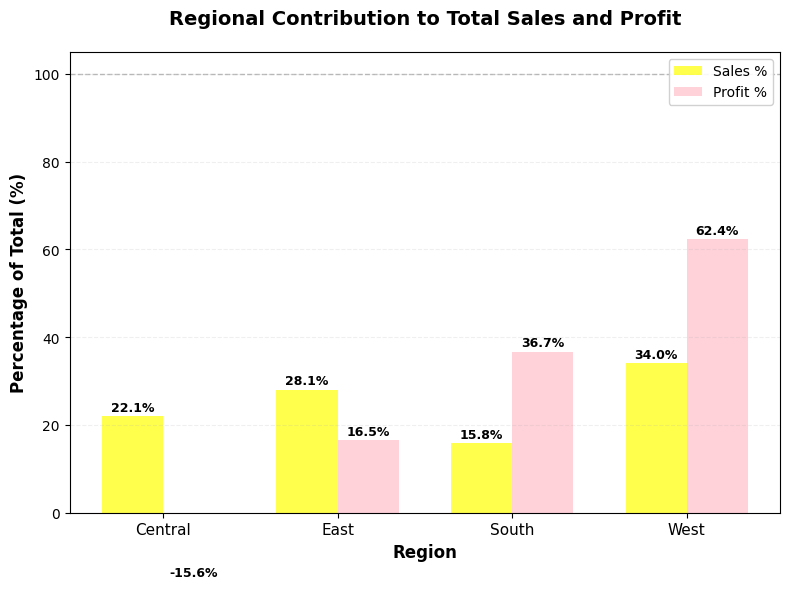

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate totals
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()

# Group by Region and calculate percentages
region_data = df.groupby('Region')[['Sales', 'Profit']].sum().reset_index()
region_data['Sales %'] = (region_data['Sales'] / total_sales) * 100
region_data['Profit %'] = (region_data['Profit'] / total_profit) * 100

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
x = range(len(region_data))

# Bars - Sales % (left) and Profit % (right)
bars1 = ax.bar([i - bar_width/2 for i in x], region_data['Sales %'],
               width=bar_width, label='Sales %', color='yellow', alpha=0.7)

bars2 = ax.bar([i + bar_width/2 for i in x], region_data['Profit %'],
               width=bar_width, label='Profit %', color='pink', alpha=0.7)

# Add percentage values on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
            f'{yval:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labels and formatting
ax.set_xlabel('Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Total (%)', fontsize=12, fontweight='bold')
ax.set_title('Regional Contribution to Total Sales and Profit',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(region_data['Region'], fontsize=11)
ax.legend(loc='upper right', framealpha=0.9)

# Reference line at 100% (total)
ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Adjust y-axis limit (corrected version)
max_percentage = max(region_data['Sales %'].max(), region_data['Profit %'].max())
ax.set_ylim(0, max(max_percentage + 10, 105))

# Add light grid for readability
ax.yaxis.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

- The West region stands out, contributing 34.0% of sales and a dominant 62.4% of total profit, making it the most profitable region.
- The South also performs well in terms of profit (36.7%) despite lower sales (15.8%), indicating strong efficiency. In contrast, the Central region has a negative profit contribution (-15.6%) despite 22.1% of total sales, suggesting losses or high costs.
- The East has decent sales (28.1%) but relatively low profit (16.5%).
- Overall, the West and South are the most profitable, while the Central region underperforms.

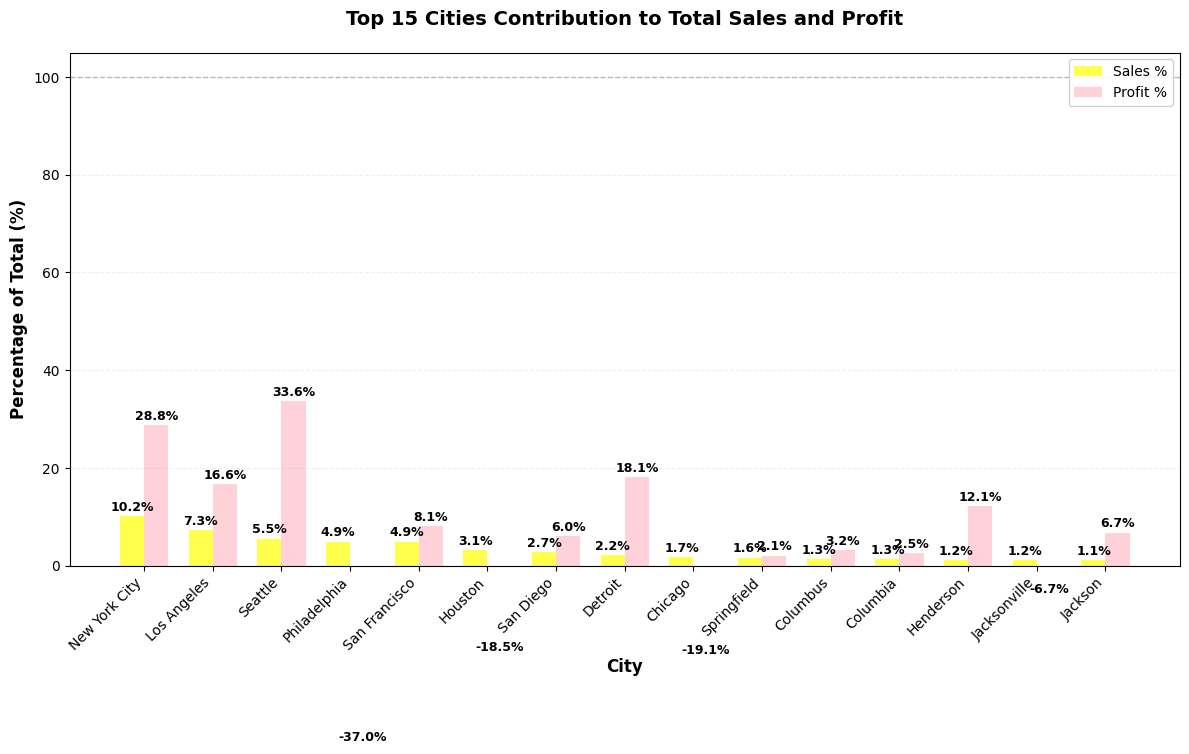

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate totals
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()

# Group by City and calculate percentages - taking top N cities for better visualization
city_data = df.groupby('City')[['Sales', 'Profit']].sum().reset_index()
city_data['Sales %'] = (city_data['Sales'] / total_sales) * 100
city_data['Profit %'] = (city_data['Profit'] / total_profit) * 100

# Sort and select top cities (adjust the number as needed)
top_n = 15  # Show top 15 cities - you can change this number
city_data = city_data.sort_values('Sales %', ascending=False).head(top_n)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Wider figure to accommodate city names
bar_width = 0.35
x = range(len(city_data))

# Bars - Sales % (left) and Profit % (right)
bars1 = ax.bar([i - bar_width/2 for i in x], city_data['Sales %'],
               width=bar_width, label='Sales %', color='yellow', alpha=0.7)

bars2 = ax.bar([i + bar_width/2 for i in x], city_data['Profit %'],
               width=bar_width, label='Profit %', color='pink', alpha=0.7)

# Add percentage values on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
            f'{yval:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labels and formatting
ax.set_xlabel('City', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Total (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Cities Contribution to Total Sales and Profit',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(city_data['City'], fontsize=10, rotation=45, ha='right')
ax.legend(loc='upper right', framealpha=0.9)

# Reference line at 100% (total)
ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Adjust y-axis limit
max_percentage = max(city_data['Sales %'].max(), city_data['Profit %'].max())
ax.set_ylim(0, max(max_percentage + 10, 105))

# Add light grid for readability
ax.yaxis.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

- Profit is good in NY, Los A, Seattle, Detroit, Henderson with the possibility to boost sales more and more
- Manager should investigate in Philadelphia, Houston, Chicago And Jacksonville
- Manager should boost sales in the rest of the cities

###  1.3 Insights from products segments :

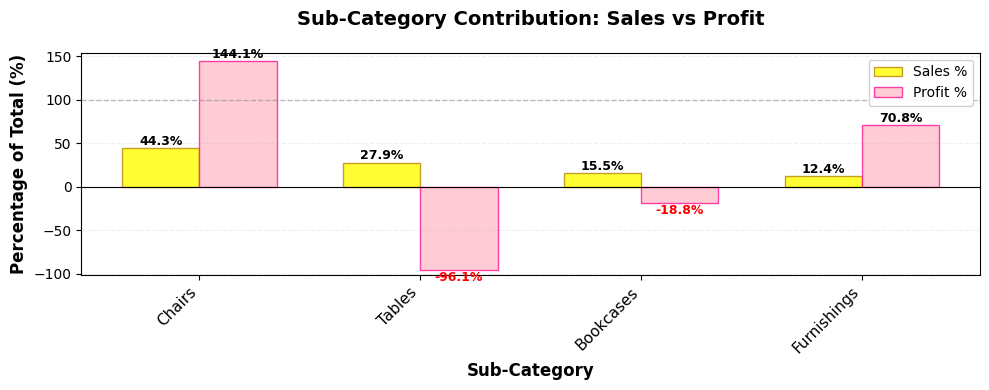

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate totals (using absolute value for profit denominator)
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
profit_denominator = abs(total_profit)  # Use absolute value to properly scale negative percentages

# Group by Sub-Category and calculate percentages
subcat_data = df.groupby('Sub-Category')[['Sales', 'Profit']].sum().reset_index()
subcat_data['Sales %'] = (subcat_data['Sales'] / total_sales) * 100
subcat_data['Profit %'] = (subcat_data['Profit'] / profit_denominator) * 100  # Allows negative values

# Sort by Sales % for better visualization
subcat_data = subcat_data.sort_values('Sales %', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))  # Extra width for sub-categories
bar_width = 0.35
x = range(len(subcat_data))

# Find value ranges for proper scaling
y_min = min(subcat_data['Profit %'].min(), 0) - 5
y_max = max(subcat_data['Sales %'].max(), subcat_data['Profit %'].max()) + 10

# Bars - Sales % (left)
bars1 = ax.bar([i - bar_width/2 for i in x], subcat_data['Sales %'],
               width=bar_width, label='Sales %', color='yellow', alpha=0.8, edgecolor='darkgoldenrod')

# Bars - Profit % (right) - will show negative values
bars2 = ax.bar([i + bar_width/2 for i in x], subcat_data['Profit %'],
               width=bar_width, label='Profit %', color='pink', alpha=0.8, edgecolor='deeppink')

# Add percentage values (with special handling for negatives)
for bar in bars1 + bars2:
    yval = bar.get_height()
    if yval >= 0:
        va = 'bottom'
        ypos = yval + 0.5
        color = 'black'
    else:
        va = 'top'
        ypos = yval - 0.5
        color = 'red'  # Make negative values stand out

    ax.text(bar.get_x() + bar.get_width()/2, ypos,
            f'{yval:.1f}%',
            ha='center', va=va, fontsize=9, fontweight='bold',
            color=color)

# Labels and formatting
ax.set_xlabel('Sub-Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Total (%)', fontsize=12, fontweight='bold')
ax.set_title('Sub-Category Contribution: Sales vs Profit',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(subcat_data['Sub-Category'], fontsize=11, rotation=45, ha='right')

# Reference lines
ax.axhline(y=0, color='black', linewidth=0.8)  # Zero line
ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)  # 100% reference

# Set y-axis limits to show negatives
ax.set_ylim(y_min, y_max)

# Add legend and grid
ax.legend(loc='upper right', framealpha=0.9)
ax.yaxis.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

- Chairs are the top-performing sub-category, with high sales and strong profitability.

- Tables and Bookcases are generating losses despite sales, managers should analyze the causes.

- Furnishings have good sales figures, but profitability does not align with the sales volume.

###  1.4 Insights from clients segments :

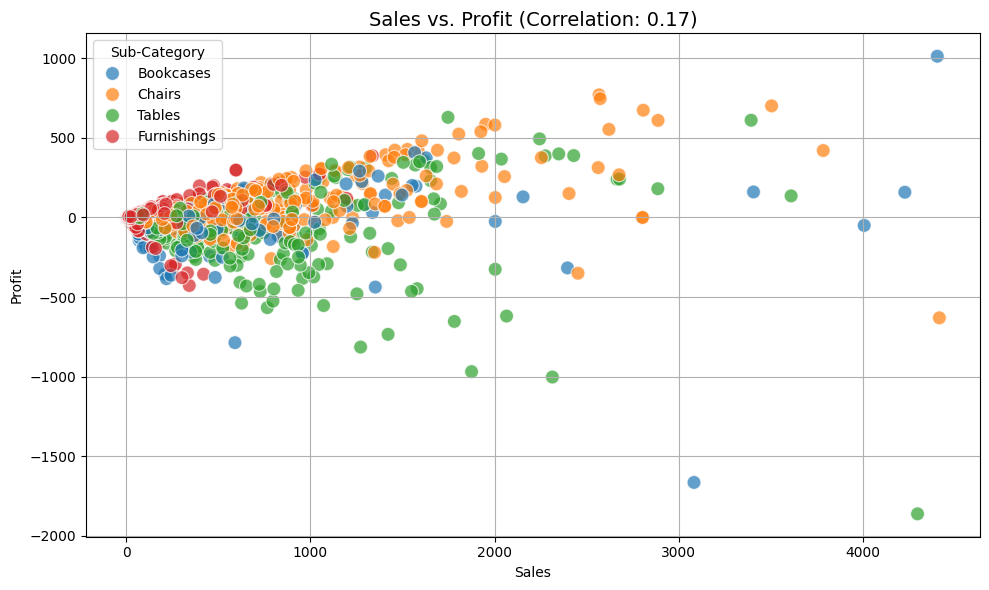

In [69]:
# Scatter plot with annotations
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='Sales',
    y='Profit',
    hue='Sub-Category',  # Color by sub-category
    s=100,              # Marker size
    alpha=0.7
)

# Add correlation coefficient
corr = df[['Sales', 'Profit']].corr().iloc[0, 1]
plt.title(f'Sales vs. Profit (Correlation: {corr:.2f})', fontsize=14)



plt.grid(True)
plt.tight_layout()
plt.show()

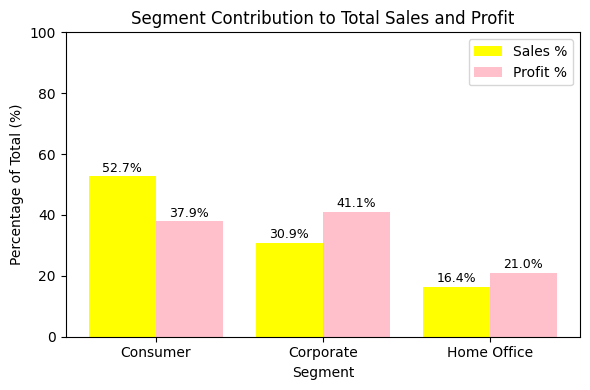

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate totals
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()

# Group by Segment and calculate percentages
segment_data = df.groupby('Segment')[['Sales', 'Profit']].sum().reset_index()
segment_data['Sales %'] = (segment_data['Sales'] / total_sales) * 100
segment_data['Profit %'] = (segment_data['Profit'] / total_profit) * 100

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4
x = range(len(segment_data))

# Bars - Sales % (left) and Profit % (right)
bars1 = ax.bar([i - bar_width/2 for i in x], segment_data['Sales %'],
               width=bar_width, label='Sales %', color='yellow')

bars2 = ax.bar([i + bar_width/2 for i in x], segment_data['Profit %'],
               width=bar_width, label='Profit %', color='pink')

# Add percentage values on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5,  # Small offset
            f'{yval:.1f}%',
            ha='center', va='bottom', fontsize=9)

# Labels and formatting
ax.set_xlabel('Segment')
ax.set_ylabel('Percentage of Total (%)')
ax.set_title('Segment Contribution to Total Sales and Profit')
ax.set_xticks(x)
ax.set_xticklabels(segment_data['Segment'])
ax.legend(loc='upper right')

# Reference line at 100% (total)
ax.axhline(y=100, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

# Set y-axis limit to accommodate the highest bar + label
ax.set_ylim(0, max(segment_data[['Sales %', 'Profit %']].max().max() + 10, 100))

plt.tight_layout()
plt.show()

- The Consumer segment leads in sales (52.7%) but contributes only 37.9% to total profit.
- In contrast, the Corporate segment, with a smaller sales share (30.9%), contributes significantly more to profit (41.1%), indicating higher profitability.
- The Home Office segment has the lowest share in both sales (16.4%) and profit (21.0%).
- Overall, the Corporate segment appears the most efficient in converting sales into profit.

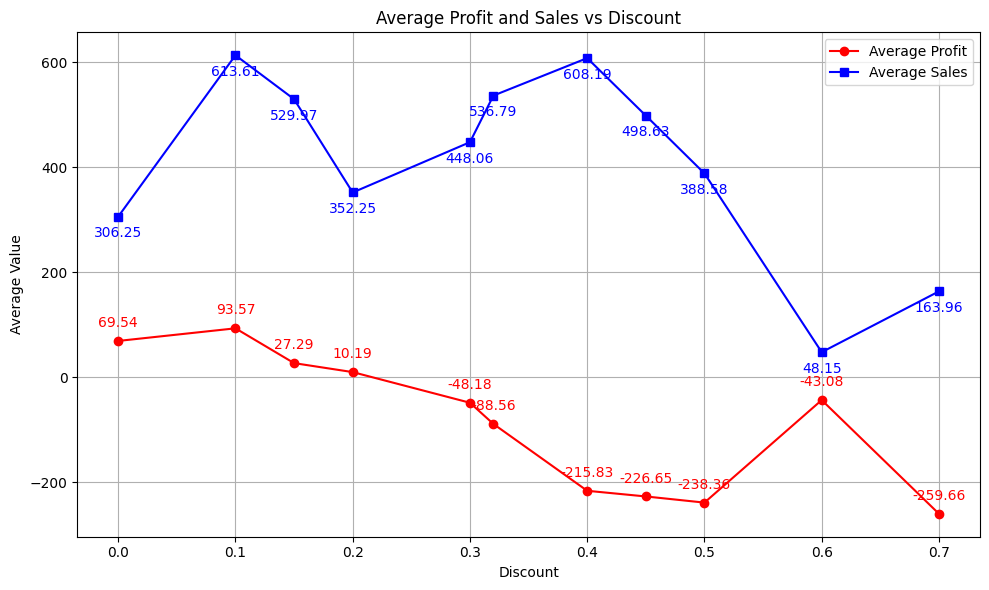

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
grouped = df.groupby('Discount')[['Profit', 'Sales']].mean().reset_index()

plt.figure(figsize=(10,6))
profit_line, = plt.plot(grouped['Discount'], grouped['Profit'], marker='o', color='red', label='Average Profit')
sales_line, = plt.plot(grouped['Discount'], grouped['Sales'], marker='s', color='blue', label='Average Sales')

# Add annotations for Profit values
for x, y in zip(grouped['Discount'], grouped['Profit']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='red')

# Add annotations for Sales values
for x, y in zip(grouped['Discount'], grouped['Sales']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', color='blue')

plt.xlabel('Discount')
plt.ylabel('Average Value')
plt.title('Average Profit and Sales vs Discount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- The data reveals a non-linear relationship between discounts and profitability.

- Key findings:

   1. Profit decrease from (10%) Discounts  

   2. Sales sharply decrease from (50%) Discounts

   3. Correlation between sales and Discount is confusing

## Question #2 : Insights et interprétation

Q2.
1. Identifie des insights qui, selon toi, peuvent contribuer à comprendre les variations des ventes.

   - Réponse : Based on the above graphs  Monthly Sales, Region Sales, City Sales , Segment Sales, Sub-Category Sales, Quantity Sales, Profit Sales and Discout Sales show clear impact on sales. They will be considered as potential candidates to train models

2. En tenant compte des parties prenantes visées par ta solution, comment interprètes-tu les résultats produits par ta solution ML? Comment cette solution ajoute-t-elle de la valeur pour ces parties prenantes?

##Réponse 2

3. Selon toi, comment envisage-tu que les parties prenantes vont utiliser ta solution pour tenter de comprendre comment augmenter les ventes?

   - Réponse : Les parties prenantes peuvent oir quelles variables influencent fortement les prédictions de ventes (par exemple, Quantity, Discount, Month, Processing Time).

   - Grâce à l’analyse de l’importance des variables (feature importance) (surtout avec des modèles comme XGBoost), elles pourront prioriser leurs actions : Ex : si Discount a une forte importance → action sur les promotions. Si Order Processing Time est important → revoir les processus logistiques, etc.

### Features Engineering
Before beginning our exploration of insights, we aim to enhance the DataFrame by adding new columns. These additional features will help us uncover semantic correlations particulary the none-linear ones with existing columns, ultimately improving our ability to forecast future sales.

In [72]:
# Prepare data for modeling
predictor.train_test_split(processed_df)
X_train, X_test = predictor.X_train, predictor.X_test
y_train, y_test = predictor.y_train, predictor.y_test

In [73]:
# Compare multiple models
model_comparator.train_models(X_train, y_train, X_test, y_test)
results_df = model_comparator.evaluate_models(y_test)


Training Linear Regression...

Training Ridge...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Training Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Training Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Training Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Training XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Training SVR...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Comparing Models:


Model Comparison (Sorted by R²):
                          MAE        RMSE        R²
XGBoost             22.062243   51.277867  0.991419
Gradient Boosting   22.891469   67.482931  0.985138
Random Forest       17.252641   80.880356  0.978651
Linear Regression  144.030969  256.559653  0.785188
Ridge              144.142822  256.646901  0.785041
Lasso              144.287475  256.961589  0.784514
SVR                129.196143  294.281329  0.717377

Best Hyperparameters:
Ridge: {'model__alpha': 10.0}
Lasso: {'model__alpha': 1.0}
Random Forest: {'model__max_depth': 10, 'model__n_estimators': 200}
Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
SVR: {'model__C': 10, 'model__kernel': 'linear'}


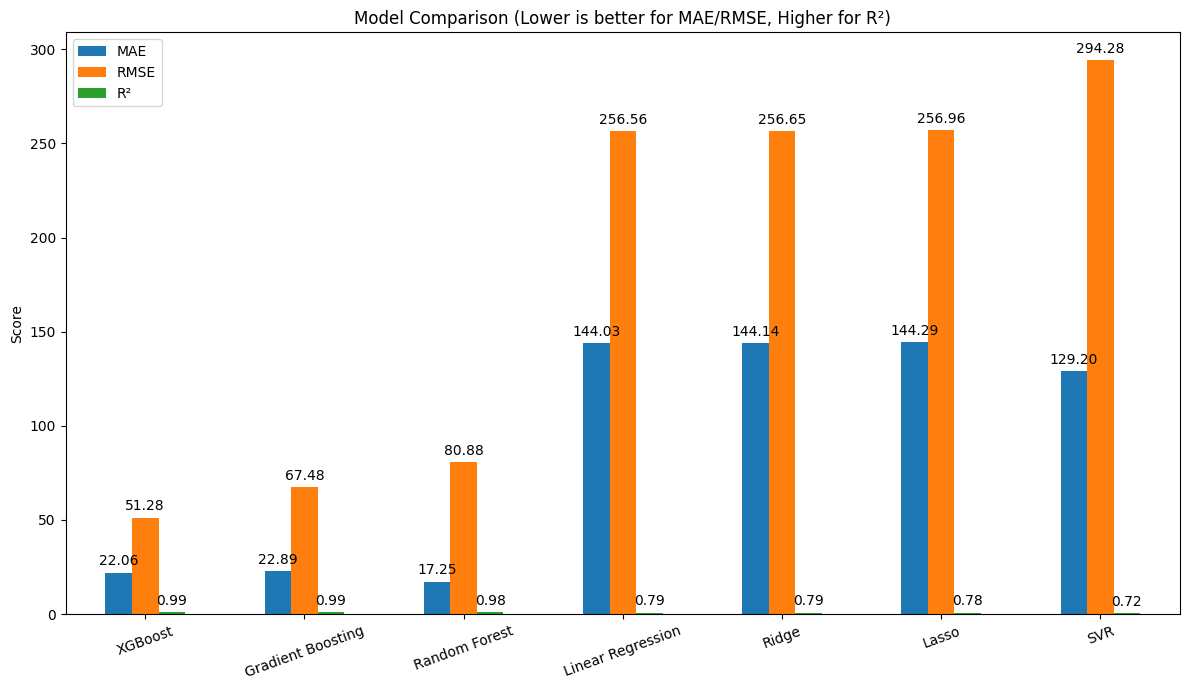

In [19]:
# Display results
model_comparator.print_results()
model_comparator.plot_comparison(figsize=(12, 7), rotation=20)  # Customize plot

### The best mode choice :

In [74]:
# Get the best model
best_model, best_model_name = model_comparator.get_best_model()
print(f"\nBest model: {best_model_name}")


Best model: XGBoost


In [75]:
# Update predictor with the best model
predictor.model = best_model

### Features Importance Explainability :


Feature Importance from SHAP Values:


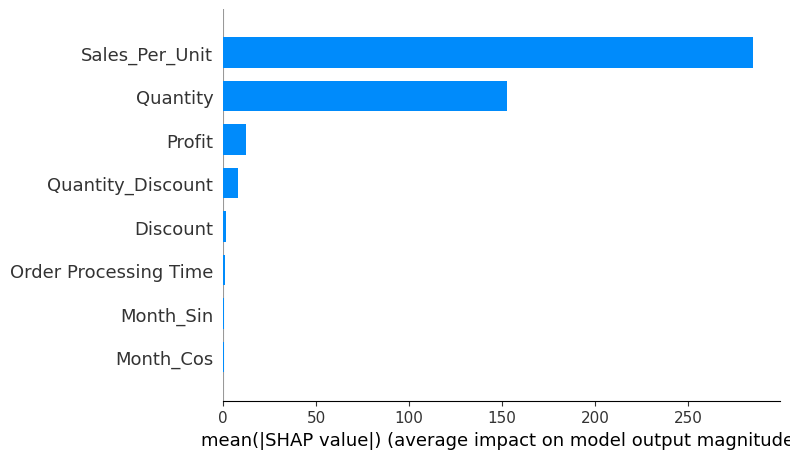

<Figure size 640x480 with 0 Axes>


SHAP Value Distribution:


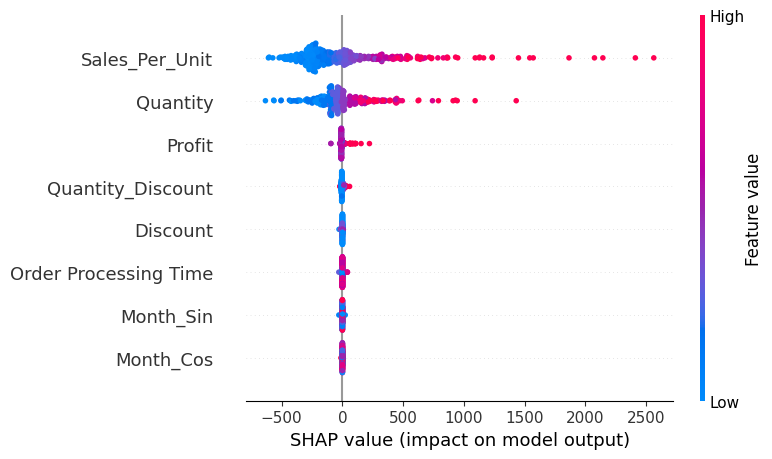

<Figure size 640x480 with 0 Axes>


SHAP Explanation for First Observation:


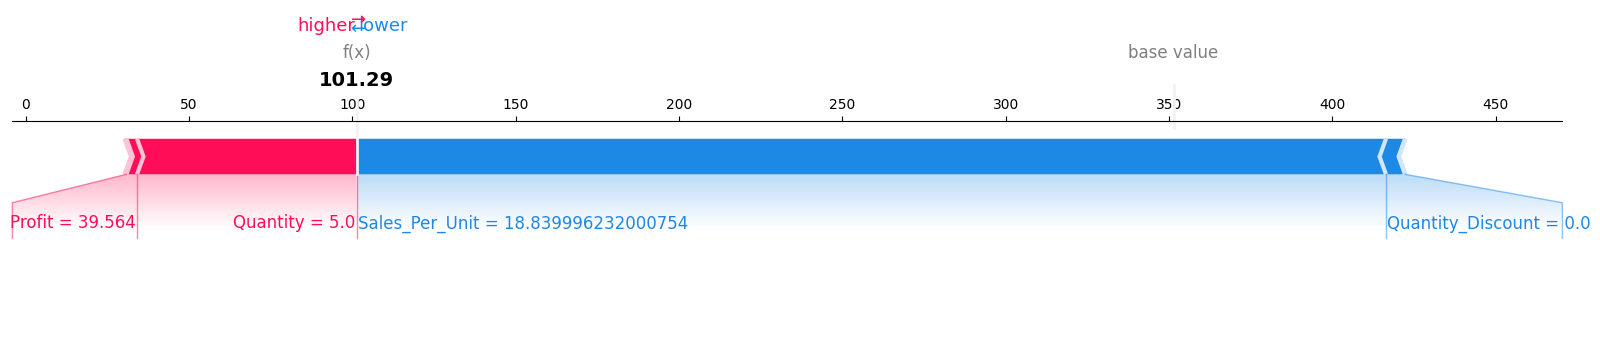

<Figure size 640x480 with 0 Axes>

In [76]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline

def explain_model_shap(best_model, X_train, X_test, feature_names=None):
    """
    Compute and visualize SHAP values for the best model.

    Args:
        best_model: Trained model or pipeline
        X_train: Training data (pd.DataFrame or np.array)
        X_test: Test data (pd.DataFrame or np.array)
        feature_names: List of feature names (optional)
    """
    # If the model is in a pipeline, extract the actual estimator
    if isinstance(best_model, Pipeline):
        model = best_model.named_steps['model']
        # If there was preprocessing, transform the data
        if len(best_model.named_steps) > 1:
            X_train = best_model[:-1].transform(X_train)
            X_test = best_model[:-1].transform(X_test)
    else:
        model = best_model

    # Handle feature names
    if feature_names is None:
        if hasattr(X_train, 'columns'):
            feature_names = X_train.columns.tolist()
        else:
            feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

    # Initialize SHAP explainer based on model type
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor, XGBRegressor)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    else:
        # For linear models or other models, use KernelExplainer
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))
        shap_values = explainer.shap_values(X_test)

    # Create visualizations
    plt.figure(figsize=(12, 8))

    # Summary plot (feature importance)
    print("\nFeature Importance from SHAP Values:")
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
    plt.tight_layout()
    plt.show()

    # Detailed summary plot
    print("\nSHAP Value Distribution:")
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    plt.tight_layout()
    plt.show()

    # Force plot for first observation
    print("\nSHAP Explanation for First Observation:")
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:] if hasattr(X_test, 'iloc') else X_test[0,:],
                   feature_names=feature_names, matplotlib=True)
    plt.tight_layout()
    plt.show()

    # Return explainer and values for further analysis
    return explainer, shap_values

# Get the feature names from your training data
feature_names = predictor.X_train.columns.tolist()
explainer, shap_values = explain_model_shap(best_model=best_model, X_train=predictor.X_train, X_test=predictor.X_test,feature_names=feature_names)

shap values explain the importance and the influence of the features on sales forecasting from top (important) to down (less important)

##Question #3 : Solution ML

Q3. Décris l'approche ML que tu as utilisé pour prévoir les ventes. Pourquoi as-tu choisi cette approche? Quels sont les avantages et les inconvénients de cette approche?

##Réponse 3
1. Préparation des données
 - Calcul des correlation entre features numérique et visualisation avec heatmap pour avoir une idée sur la relation entre les features.

 - Sélection des features les pertinentes liées aux ventes comme candidats.

 - Création de variables d’interaction (Order Process Time, Quantity × Discount, Profit ÷ Sales, etc.) pour capturer les relations non linéaires.

 - Transformation cyclique de Month (sin, cos) pour modéliser la saisonnalité qui est tres utilisée dans le contexte des ventes.

 - Élimination des variables redondantes ou peu informatives pour réduire la complexité (Region, City donne la meme information, Country, category,Year etc sont tres peux informatifs).

2. Comparaison de plusieurs modèles ML

 - forecasting les ventes est un problème qui releve des modeles de regression

 - Utilisation de différents modèles supervisés de régression :

   1. Régressions linéaires (Linear, Ridge, Lasso)

   2. Arbres de décision (Random Forest, Gradient Boosting, XGBoost)

   3. Modèle à noyau (SVR)

3. Évaluation comparative de tous les modeles avec les métriques MAE, RMSE, R².

4. Utilisation de GridSearchCV pour optimiser le finetuning

5. Sélection du meilleur modèle (XGBoost) selon la performance (R² ≈ 0.71).

6. Utilisation de la technique SHAP Value pour expliquer XGBoot et voir l'importance des variables afin de voir laquelle est la plus influencente sur les sales.

##Question #4 : Dégradation de la performance



Q4. Imaginons que ta solution est déployée et roule maintenant en production. Tu remarques que la performance de ton modèle se dégrade progressivement depuis les derniers mois. De plus, tu identifies également certaines variables dont les valeurs semblent avoir évolué durant la même période. Selon toi, quelle serait une raison qui explique cette situation et comment la résoudrais-tu ?

##Réponse 4 :
1. Hypothèse principale : Drift de données, autrement dit le comportement des données en production n’est plus le même que celui observé pendant l’entraînement. Deux formes possibles :

    - Data Drift c'est a dire changement sur le X, en d'autres termes, La distribution des variables explicatives (Discount, Quantity, etc.) a changé comme par exemple l'augmentation du niveau moyen de discount ou de la durée de traitement des commandes.
    - Concept Drift qui est un changement dans la relation X → y. Les relations entre les variables explicatives et la variable cible Sales ont évolué. Comme par exemple une réduction importante n’entraîne plus autant de ventes qu’avant en raison d’une saturation du marché ou d’un changement de comportement des clients.

2. Stratégie pour le diagnostique et la correction

  - Étape 1 : Détection
      1. Comparer les distributions de variables entre les données d’entraînement et les données récentes en production (avec des outils comme Kolmogorov&Smirnov test, Population Stability Index (PSI)).

      2. Surveiller les performances du modèle dans le temps (ex : R², RMSE par mois).

      3. Visualiser les variables impactées (ex : histogrammes ou boxplots de Discount, Quantity, etc.).

  - Étape 2 : Alternative ou Solution possible
      1. Collecter les données récentes et les ajouter à un nouveau jeu d'entraînement. Recalibrer et Réentraîner le modèle.
      2. Utiliser un modèle plus adaptable en cas de beaucoup de variation comme l'online learning ou modèles retrainables régulièrement.

      3. Mettre en place une stratégie de monitoring real time.
afin de surveiller et tracker :
        - la performance prédictive (R², MAE…)
        - les drifts de variables via des dashboards.
        - Création des alertes automatiques


##Question #5 : Intégration de l'IA générative


Q5. Comment l'IA générative pourrait-elle être intégrée dans un système de prévision des ventes pour soutenir les utilisateurs finaux de ce modèle?
 - Donne un exemple d'architecture où l'IA générative pourrait être utilisée.
 - Propose un exemple de prompt qui pourrait être utilisé pour interagir avec l'IA générative.

##Réponse 5 :
L’IA générative peut jouer un rôle complémentaire aux modèles prédictifs classiques en :

   - Soutenant les utilisateurs finaux à plusieurs niveaux :
     Interprétation des prédictions en langage naturel

   - Donner des recommandations d’actions en se basant sur les données de ventes et les tendances.

   - Exploration interactive : permettre aux utilisateurs non techniques de poser des questions comme :

      - Prompt1 : “Pourquoi les ventes chutent-elles en mars ?” ou
      - Prompt2 : “Quel scénario me permettrait d’atteindre 15% de croissance ?”

                          ┌────────────────────────────┐
                          │        Interface UI         │
                          │ (Web App : Dashboard + Chat)│
                          └────────────┬────────────────┘
                                       │
                                       ▼
                         ┌────────────────────────────┐
                         │     API Interne Gateway     │
                         │ (Flask / FastAPI / Node.js) │
                         └────────┬──────────┬─────────┘
                                  │          │
                                  ▼          ▼
         ┌───────────────────────────────┐   ┌─────────────────────────────┐
         │   Module de Prévision (ML)    │   │    Moteur IA Générative     │
         │  (XGBoost, RF, LSTM, etc.)    │   │ (ChatGPT / OpenAI API /     │
         │                               │   │  Mistral, LLaMA2 via LangChain) │
         └────────────┬──────────────────┘   └────────────────────┬────────┘
                      │                                           │
       ┌──────────────▼──────────────┐             ┌──────────────▼──────────────┐
       │     Feature Store /         │             │     Orchestrateur de        │
       │    Modèle de données        │             │  Prompts & Requêtes LLM     │
       │ (historique, prévisions,    │             │ (templating, context mgmt.) │
       │   discount, régions, etc.)  │             └─────────────────────────────┘
       └──────────────┬──────────────┘
                      │
                      ▼
         ┌──────────────────────────────────┐
         │   Data Lake / Data Warehouse     │
         │ (    Snowflake, BigQuery, S3)    │
         └──────────────────────────────────┘



- Fonctionnement :
   1. L’utilisateur pose une question en langage naturel.

   2. Le système génère un prompt enrichi automatiquement en fonction des données récentes (prévisions du modèle, indicateurs clés).

   3. L’IA générative répond intelligemment, en donnant du contexte, des analyses, ou des recommandations.

- Scénario

Paul est un analiste de ventes.

Paul écrit :

    Voici les données de ventes prévues pour les trois prochains mois :
    - Janvier : 42 000$
    - Février : 37 000$
    - Mars : 33 000$
    - Les produits en promotion sont : "Casques audio", "Écrans 27 pouces"
    - Le discount moyen appliqué est passé de 5% à 12% au cours des 2 derniers mois.

    Analyse cette situation et suggère deux actions marketing ou logistiques pour améliorer les ventes en mars. Sois concis et oriente tes réponses vers un responsable commercial.


Thanks Paul ! ⏰